# Задание:

Cпрогнозировать выручку с августа 2015 по конец 2016 года

# Решение:

Импортируем необходимые модули:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import statsmodels
from itertools import product
import warnings
from dateutil.relativedelta import relativedelta
import datetime
from tqdm import tqdm_notebook

%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Загрузим временной ряд в таблицу, преобразовав ординату к значениям невысокого порядка (это понадобится в дальнейшем для исключения ошибок при работе модели). Посмотрим на начало и конец таблицы, а также на типы данных в колонках.

In [2]:
df = pd.read_csv('proceeds.csv', sep=',', names=['year', 'month', 'proceeds'], header=0)
df.proceeds *= 1e-7

In [3]:
df.head()

,year,month,proceeds
0,2010,1,9.767625
1,2010,2,9.552271
2,2010,3,11.938705
3,2010,4,9.438320
4,2010,5,9.060580


In [4]:
df.tail()

,year,month,proceeds
79,2016,8,NaN
80,2016,9,NaN
81,2016,10,NaN
82,2016,11,NaN
83,2016,12,NaN


In [5]:
df.dtypes

year          int64
month         int64
proceeds    float64
dtype: object

Приведем таблицу к виду <время>-<значение>, объединив колонки **year** и **month** (с последующим их удалением) и преобразовав новую колонку к типу **datetime**. Кроме того, удалим все строки с NaN.

In [6]:
df['time'] = df.apply(lambda row: str(int(row['year'])) + '-' + str(int(row['month'])), axis=1)
df['time'] = pd.to_datetime(df['time'])
df = df[[df.columns[-1]] + list(df.columns[:-1])]
df = df.set_index('time').dropna()
del df['year'], df['month']

In [7]:
df.head()

,proceeds
time,
2010-01-01,9.767625
2010-02-01,9.552271
2010-03-01,11.938705
2010-04-01,9.438320
2010-05-01,9.060580


In [8]:
df.tail()

,proceeds
time,
2015-03-01,16.738511
2015-04-01,15.137116
2015-05-01,15.433158
2015-06-01,16.420646
2015-07-01,16.895605


Построим временной ряд:

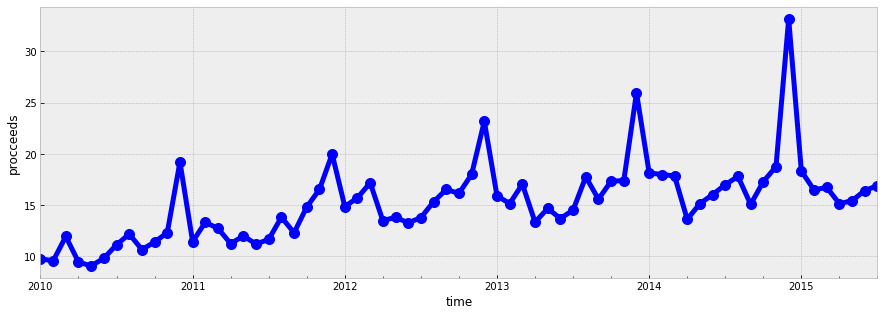

In [9]:
plt.figure(figsize=(15,5))
plt.style.use('bmh')
df.proceeds.plot(color='blue', marker='o', markersize=10, linewidth=5)
plt.ylabel('procceeds')
plt.show()

Используя STL-разложение, посмотрим на тренд, сезонность и остатки.

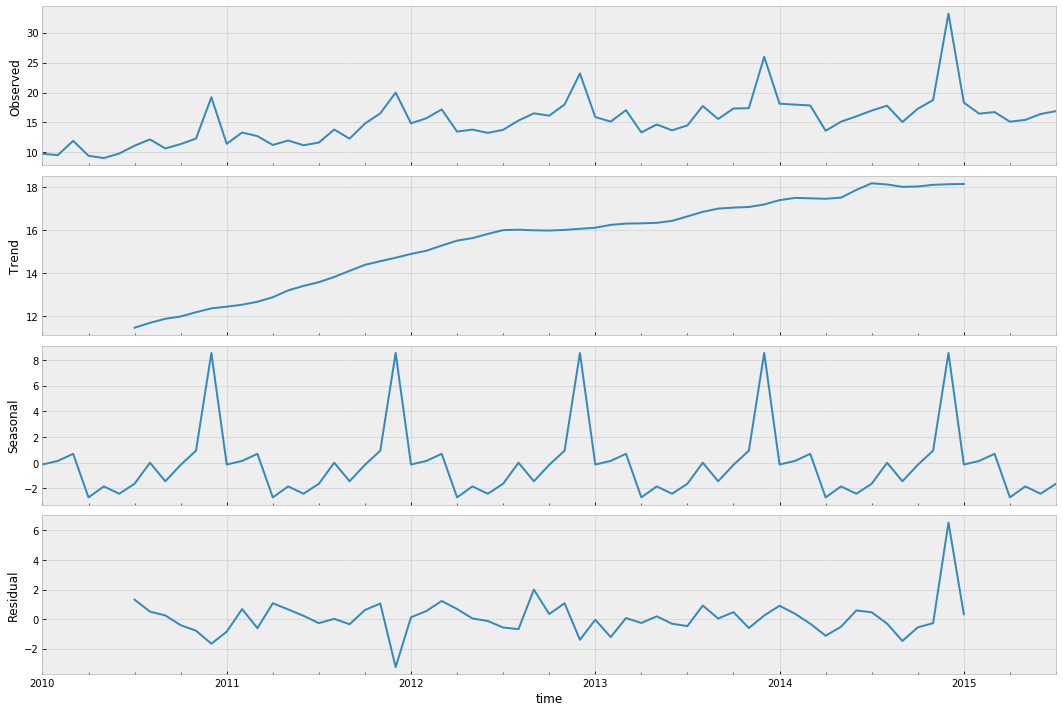

In [10]:
plt.rcParams["figure.figsize"] = (15,10)
plt.style.use('bmh')
sm.tsa.seasonal_decompose(df.proceeds).plot()
plt.show()

Виден восходящий тренд, а также явно выраженная сезонность.

Проверим гипотезу нестационарности ряда с помощью критерия Дики-Фуллера:

In [11]:
print('Критерий Дики-Фуллера: p=%f'% sm.tsa.stattools.adfuller(df.proceeds)[1])

Критерий Дики-Фуллера: p=0.022805


Исходя из пограничного значения достигаемого уровня значимости, можно сказать, что желательно уменьшить дисперсию ряда, воспользовавшись, например, преобразованием Бокса-Кокса.

In [12]:
df['proceeds_boxcox'], lmbda = stats.boxcox(df.proceeds)

In [13]:
print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(df.proceeds_boxcox)[1])

Оптимальный параметр преобразования Бокса-Кокса: -0.374499
Критерий Дики-Фуллера: p=0.000046


После преобразования Бокса-Кокса гипотезу о нестационарности с уверенностью можно отвергнуть. Посмотрим на то, как изменился ряд:

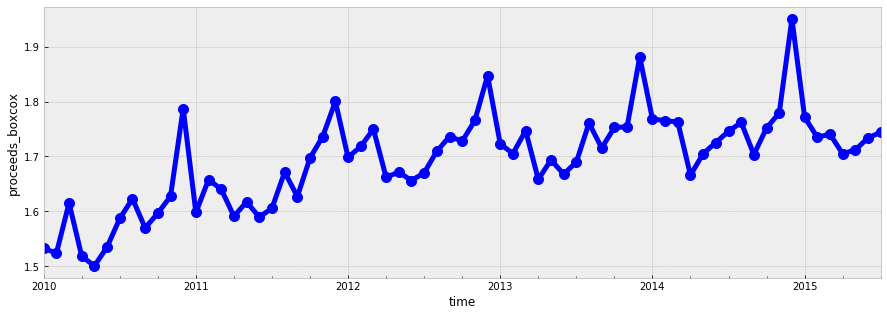

In [14]:
plt.figure(figsize=(15,5))
plt.style.use('bmh')
df.proceeds_boxcox.plot(color='blue', marker='o', markersize=10, linewidth=5)
plt.ylabel('proceeds_boxcox')
plt.show()

Действительно, пики на графике стали более схожими, стабилизировав дисперсию ряда.

Согласно теореме Вольда, любой стационарный ряд может быть описан авторегрессионной моделью класса *ARMA(p,q)*, в частности *SARIMA(p,d,q,P,D,Q)*, с любой наперед заданной точностью. Применим ее для данного ряда.

Сначала, попытаемся найти нулевые приближения для гиперпараметров модели. Сразу оговоримся, что наш преобразованный ряд стационарен и дополнительные дифференцирования (как внутрисезонные, так и сезонные) не требуются, поэтому параметры d и D, можно занулить. Для оценки q, Q и p, P построим графики автокорреляционной и частичной автокорреляционной функции соответственно:

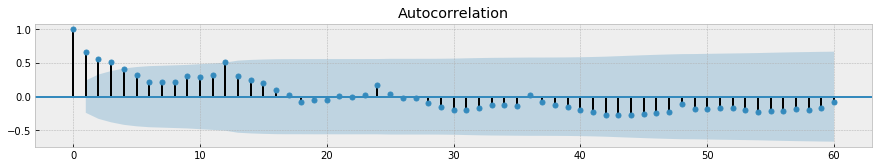

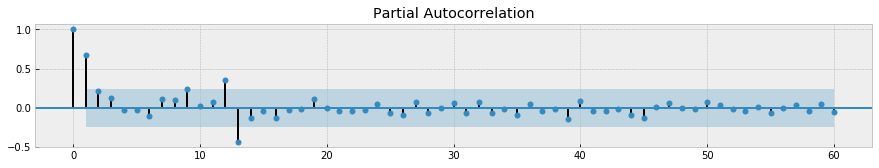

In [15]:
plt.rcParams["figure.figsize"] = (15,5)
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.proceeds_boxcox.values.squeeze(), lags=60, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.proceeds_boxcox.values.squeeze(), lags=60, ax=ax)
plt.show()

Видно, что последний значимый несезонный лаг на графике АКФ равен $q=3$. Единственный сезонный лаг $S \times Q = 12$. Поскольку $S=12$, получаем $Q=1$. Последний значимый несезонный лаг на графике чАКФ равен $p=1$. Единственный сезонный лаг $S \times P = 12$, значит $P=1$.

Итого: 
* q=3
* Q=1
* p=1
* P=1

Выбрав начальное приближение, создадим сетку гиперпараметров в районе начальных приближений, в которой будем искать оптимальные значения с точки зрений информационного критерия Акаике. 

Кроме того, необходимо проанализировать остатки модели. Поэтому для каждой модели:
* проверим критерием Стьюдента равенство среднего значения остатков нулю
* проверим критерием Дики-Фуллера гипотезу о нестационарности остатков
* проверим критерием Льюонга-Бокса гипотезу о неавтокоррелированности остатков

In [16]:
p = range(1,4)
q = range(1,5)
d = range(0,3)
P = range(0,3)
Q = range(0,3)
D = range(0,3)
parameters = list((product(p, d, q, P, D, Q)))
print(len(parameters))

972


In [17]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm_notebook(parameters):
    try:
        model = sm.tsa.statespace.SARIMAX(df.proceeds_boxcox, order = (param[0], param[1], param[2]), \
                                          seasonal_order = (param[3], param[4], param[5], 12)).fit(disp=-1)
    except:
        continue
    p_student = stats.ttest_1samp(model.resid, 0)[1]
    p_fuller = sm.tsa.stattools.adfuller(model.resid)[1]
    p_ljung = statsmodels.stats.diagnostic.acorr_ljungbox(model.resid)[1].min()
    results.append([param, model.aic, p_student, p_fuller, p_ljung, model])


Wall time: 3min 31s


Посмотрим на топ 5 комбинаций гиперпараметров:

In [18]:
result = pd.DataFrame(results)
result.columns = ['parameters', 'aic', 'p_student', 'p_fuller', 'p_ljung', 'model']
results = result.sort_values(by='aic', ascending=True).reset_index(drop=True)
results[['parameters', 'aic', 'p_student', 'p_fuller', 'p_ljung']].head(20)

,parameters,aic,p_student,p_fuller,p_ljung
0,"(1, 1, 1, 2, 0, 0)",-242.228087,0.295018,0.199178,0.889108
1,"(2, 1, 1, 2, 0, 0)",-240.428514,0.295739,0.188120,0.881045
2,"(1, 1, 1, 1, 0, 0)",-239.177804,0.268876,0.209190,0.893599
3,"(1, 1, 3, 2, 0, 0)",-239.032713,0.297517,0.000000,0.894356
4,"(3, 1, 1, 2, 0, 0)",-238.905918,0.304175,0.259909,0.880909
5,"(2, 1, 1, 1, 0, 0)",-237.525958,0.271983,0.188830,0.882970
6,"(3, 1, 1, 1, 0, 0)",-236.861337,0.277726,0.162871,0.879190
7,"(1, 1, 3, 1, 0, 0)",-235.196761,0.268832,0.209581,0.892474
8,"(1, 1, 4, 1, 0, 0)",-233.995494,0.275738,0.179910,0.883629
9,"(2, 1, 4, 1, 0, 0)",-232.103337,0.275897,0.183455,0.884267


Поскольку необходимо, чтобы остатки имели нулевое среднее значение, были стационарны и неавтокоррелированы, то оптимальным с точки зрения критерия AIC будет модель под номером 3 с параметрами $p=1, \ d=1, \ q=3, \ P=2, \ D=0, \ Q=0$.

In [19]:
best_model = results['model'][3]

Подробнее про лучшую модель:

In [20]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    proceeds_boxcox   No. Observations:                   67
Model:             SARIMAX(1, 1, 3)x(2, 0, 0, 12)   Log Likelihood                 126.516
Date:                            Mon, 06 Nov 2017   AIC                           -239.033
Time:                                    14:35:48   BIC                           -223.600
Sample:                                01-01-2010   HQIC                          -232.926
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5640      0.797     -0.708      0.479      -2.126       0.998
ma.L1         -0.0829      0.748   

Посмотрим на остатки лучшей модели:  

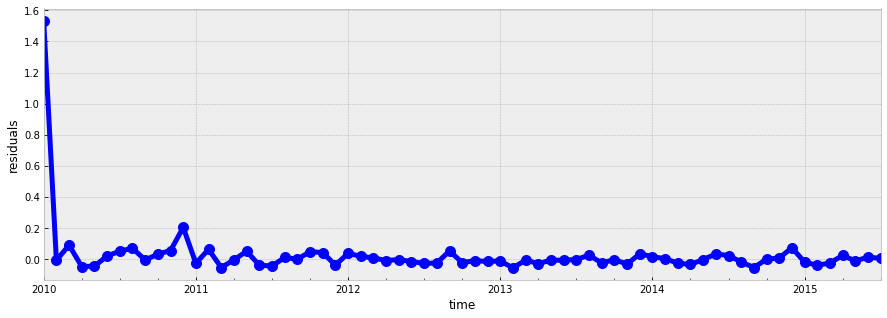

In [21]:
plt.rcParams["figure.figsize"] = (15,5)
plt.style.use('bmh')
best_model.resid.plot(color='blue', marker='o', markersize=10, linewidth=5)
plt.ylabel('residuals')
plt.show()

Графики АКФ и чАКФ:

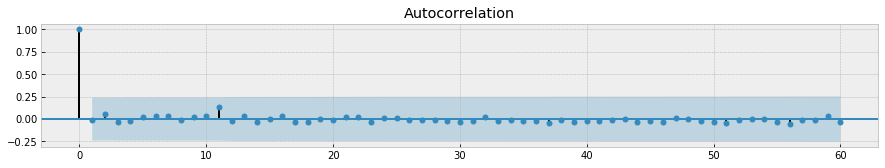

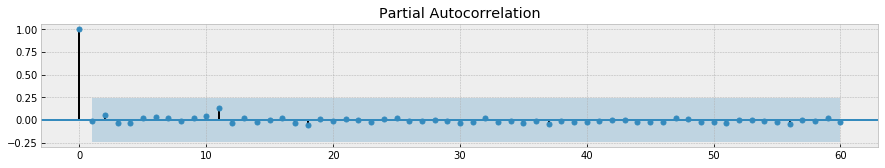

In [22]:
plt.rcParams["figure.figsize"] = (15,5)
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(best_model.resid, lags=60, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(best_model.resid, lags=60, ax=ax)
plt.show()

Построим график выбранной нами модели на исторических данных:

In [23]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

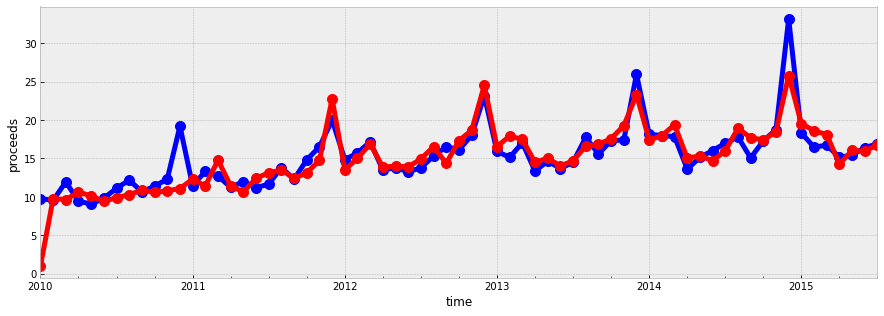

In [24]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.rcParams["figure.figsize"] = (15,5)
plt.style.use('bmh')
df.proceeds.plot(color='blue', marker='o', markersize=10, linewidth=5)
df.model.plot(color='red', marker='o', markersize=10, linewidth=5)
plt.ylabel('proceeds')
plt.show()

Видно, что модель с некоторой погрешностью, но все же повторяет динамику выручки за известный период. Построим предсказание на период с августа 2015 до конца 2016го, как требовалось в условии:

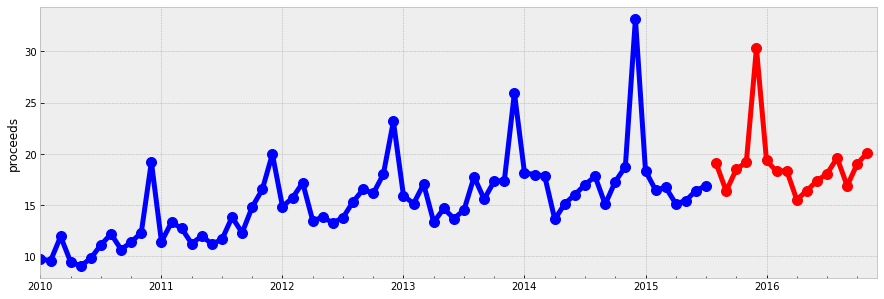

In [25]:
df2 = df[['proceeds']]
date_list = [datetime.datetime.strptime("2015-08-01", "%Y-%m-%d") + relativedelta(months = x) for x in range(0, 17)]
future = pd.DataFrame(index=date_list, columns=df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start = df.shape[0], end=df.shape[0]+15), lmbda)

plt.rcParams["figure.figsize"] = (15,5)
plt.style.use('bmh')
df2.proceeds.plot(color='blue', marker='o', markersize=10, linewidth=5)
df2.forecast.plot(color='red', marker='o', markersize=10, linewidth=5)
plt.ylabel('proceeds')
plt.show()